# Stratégia rövid ismertetése

Cél:
- Egy N pontból álló idősorról szeretnénk eldönteni, hogy az bull flag-e, 7 osztályból (6 kategória egyike vagy "nem flag")

- N: szélesség
- M: magasság (a min és max értékek külünbsége)

(Folytonos idősor -t pedig tólóablak (window) használatával lehet osztályozni 🙂 )



Adat előfeldolgozás:
- Különböző méretű ("szélességű") mintáink vannak

- Szeretnénk a mintákat egységesíteni, hogy minden minta ugyanannyi N pontból álljon (ugyanolyan szélességű legyen)

(Bármilyen időpontokról és időközökről való információt elhanyagoltam)

Normalizálás:
- Kisebb flagek: interpoláció :)
- Nagyobb flagek: downsampling

Mi legyen az N?



In [1]:
import os
import glob
import json
import pandas as pd
import numpy as np

# --- Configuration ---
# STARTING_FOLDER: The main folder containing your child folders
STARTING_FOLDER = '/app/data/raw'
OUTPUT_ROOT_PATH = "/app/data/processed"
TRIM_N = 9
CREATE_CSV = False #debug purposes, create CSV of timestamp, price

os.makedirs(OUTPUT_ROOT_PATH, exist_ok=True)

def clean_timestamps_vectorized(series):
    """
    Vectorized function to handle mixed timestamp formats (Unix str & Date str).
    Returns integer timestamps in SECONDS (Unix Epoch).
    """
    series = series.astype(str)
    numeric = pd.to_numeric(series, errors='coerce')
    mask_dates = numeric.isna()

    if mask_dates.any():
        dates = pd.to_datetime(series[mask_dates], errors='coerce')
        # Convert to SECONDS (Unix Standard)
        numeric.loc[mask_dates] = dates.astype(np.int64) // 10**9

    return numeric.fillna(0).astype('int64')

def process_subfolder(folder_path, cwd):
    """
    Processes a single subfolder.
    Returns a list of records (dicts) for the master CSV.
    """
    records = []
    folder_name = os.path.basename(folder_path)
    print(f"\n--- Processing Subfolder: {folder_name} ---")

    json_path_pattern = os.path.join(folder_path, "*.json")
    json_files = glob.glob(json_path_pattern)

    if not json_files:
        print(f"Skipping {folder_name}: No JSON file found.")
        return []

    json_file_path = json_files[0]

    # Create the 'processed_data' folder inside the subfolder
    output_path = os.path.join(OUTPUT_ROOT_PATH, folder_name)
    os.makedirs(output_path, exist_ok=True)

    try:
        with open(json_file_path, 'r') as f:
            data_list = json.load(f)
    except Exception as e:
        print(f"Error loading JSON in {folder_name}: {e}")
        return []

    for entry in data_list:
        json_filename = entry.get('file_upload')

        # Clean filename logic (removing prefixes)
        if json_filename and len(json_filename) > TRIM_N:
            real_csv_name = json_filename[TRIM_N:]
        else:
            real_csv_name = json_filename

        input_csv_path = os.path.join(folder_path, real_csv_name)

        if not real_csv_name or not os.path.exists(input_csv_path):
            print(f"  [!] Missing file: {real_csv_name}")
            continue

        print(f"  Processing: {real_csv_name}")

        # ---------------------------------------------------------
        # STEP 1: Process Main Data CSV
        # ---------------------------------------------------------
        try:
            df = pd.read_csv(input_csv_path, dtype={'timestamp': str})

            # --- CHANGE: specific check for "Close" vs "close" ---
            if 'Close' in df.columns and 'close' not in df.columns:
                df.rename(columns={'Close': 'close'}, inplace=True)

            if 'timestamp' in df.columns and 'close' in df.columns:
                df['timestamp'] = clean_timestamps_vectorized(df['timestamp'])
                df.sort_values('timestamp', inplace=True)
            else:
                print(f"    -> Warning: File skipped, columns missing in {real_csv_name} (Found: {list(df.columns)})")
                continue
        except Exception as e:
            print(f"    -> Error reading CSV: {e}")
            continue

        # ---------------------------------------------------------
        # STEP 2: Extract Labels
        # ---------------------------------------------------------
        raw_labels = []
        for annotation in entry.get('annotations', []):
            for result in annotation.get('result', []):
                if result.get('type') == 'timeserieslabels':
                    value = result.get('value', {})
                    ts_labels = value.get('timeserieslabels', [])
                    label_name = ts_labels[0] if ts_labels else None

                    if label_name:
                        raw_labels.append({
                            'flag_type': label_name,
                            'start': value.get('start'),
                            'end': value.get('end')
                        })

        if not raw_labels:
            print(f"    -> No labels found for {real_csv_name}")
            continue

        df_labels = pd.DataFrame(raw_labels)
        df_labels['start'] = clean_timestamps_vectorized(df_labels['start'])
        df_labels['end'] = clean_timestamps_vectorized(df_labels['end'])

        # ---------------------------------------------------------
        # STEP 3: Create Slices & Accumulate Metadata
        # ---------------------------------------------------------
        for _, row in df_labels.iterrows():
            label_name = row['flag_type']
            start_ts = row['start']
            end_ts = row['end']

            # Create Class Folder (inside the OUTPUT_ROOT_FOLDER processed_data)
            class_dir = os.path.join(output_path, label_name)
            os.makedirs(class_dir, exist_ok=True)

            # Filter Main Data
            mask_slice = (df['timestamp'] >= start_ts) & (df['timestamp'] <= end_ts)
            df_slice = df.loc[mask_slice, ['timestamp', 'close']]

            if not df_slice.empty:
                # Remove '.csv' extension from the input filename
                clean_name_base = real_csv_name.replace('.csv', '')

                # Construct base name
                base_name = f"{clean_name_base}_{start_ts}_{end_ts}"

                csv_filename = base_name + ".csv"
                npy_filename = base_name + ".npy"

                # Create Absolute Full Paths
                csv_full_path = os.path.abspath(os.path.join(class_dir, csv_filename))
                npy_full_path = os.path.abspath(os.path.join(class_dir, npy_filename))

                # Save Data
                df_slice.to_csv(csv_full_path, index=False)

                prices_array = df_slice['close'].values
                if len(prices_array) != len(df_slice):
                    raise ValueError("Length mismatch between CSV and NPY array")
                np.save(npy_full_path, prices_array)

                # Add to Local Record List
                records.append({
                    "processed_folder_name": folder_name, # New Column
                    "input_csv_file": real_csv_name,
                    "flag_type": label_name,
                    "start": start_ts,
                    "end": end_ts,
                    "flag_csv_full_path": csv_full_path,
                    "flag_prices_npy_full_path": npy_full_path,
                    "flag_length": len(prices_array)
                })

        print(f"    -> Slices generated.")

    return records

In [2]:
def process_root_data_folder():
    # 1. Capture the absolute path of your current working directory
    cwd = os.path.abspath(os.getcwd())
    print(f"DEBUG: Script running from CWD: {cwd}")

    if not os.path.exists(STARTING_FOLDER):
        print(f"Error: Starting folder '{STARTING_FOLDER}' does not exist.")
        return

    all_consolidated_records = []

    # --- NEW: Define subfolders to skip ---
    SUBFOLDERS_TO_SKIP = ['TYEGJ8','VWXUD6', 'consensus', 'sample'] # Add folder names here

    # 2. Iterate through all items in the STARTING_FOLDER
    # --- CHANGE: Wrap os.listdir in sorted() to ensure order ---
    items = sorted(os.listdir(STARTING_FOLDER))

    # Filter only directories
    subfolders = [os.path.join(STARTING_FOLDER, item) for item in items if os.path.isdir(os.path.join(STARTING_FOLDER, item))]

    print(f"Found {len(subfolders)} subfolders to process.")

    # 3. Process each subfolder
    for subfolder_path in subfolders:
        subfolder_name = os.path.basename(subfolder_path)
        if subfolder_name in SUBFOLDERS_TO_SKIP:
            print(f"Skipping subfolder: {subfolder_name} (as requested).")
            continue

        subfolder_records = process_subfolder(subfolder_path, cwd)
        all_consolidated_records.extend(subfolder_records)

    # 4. Save the SINGLE Master Consolidated CSV in the OUTPUT_ROOT_PATH
    if all_consolidated_records:
        master_df = pd.DataFrame(all_consolidated_records)

        master_csv_path = os.path.join(OUTPUT_ROOT_PATH, "consolidated_labels.csv")

        cols = [
            "processed_folder_name",
            "input_csv_file",
            "flag_type",
            "start",
            "end",
            "flag_csv_full_path",
            "flag_prices_npy_full_path",
            "flag_length"
        ]
        master_df = master_df[cols]

        master_df.to_csv(master_csv_path, index=False)
        print(f"\n==================================================")
        print(f"[Success] Master consolidated file saved at:\n{master_csv_path}")
        print(f"Total records: {len(master_df)}")
        print(f"==================================================")
        return master_df
    else:
        print("\n[Info] No valid labels processed in any folder.")

In [3]:
df = process_root_data_folder()
df.head()

DEBUG: Script running from CWD: /app/notebook
Found 23 subfolders to process.

--- Processing Subfolder: AS76HW ---
  Processing: XAU_1h_data_limited.csv
    -> Slices generated.
  Processing: XAU_1m_data_limited.csv
    -> Slices generated.
  Processing: XAU_5m_data_limited.csv
    -> Slices generated.
  Processing: XAU_15m_data_limited.csv
    -> Slices generated.
  Processing: XAU_30m_data_limited.csv
    -> Slices generated.

--- Processing Subfolder: AY1PC8 ---
  Processing: EURUSD_1H_005.csv
    -> Slices generated.
  Processing: EURUSD_1min_001.csv
    -> Slices generated.

--- Processing Subfolder: DMQSIV ---
  [!] Missing file: XAU_30min_001_converted.csv
  [!] Missing file: EURUSD_15min_001_converted_fixed.csv

--- Processing Subfolder: DO1H50 ---
  Processing: EURUSD_1hour_001.csv
    -> Slices generated.
  Processing: EURUSD_1minute_001.csv
    -> Slices generated.

--- Processing Subfolder: GFTYRV ---
  Processing: GSPC_2025-09-25_to_2025-09-29_5m.csv
    -> Slices generat

,processed_folder_name,input_csv_file,flag_type,start,end,flag_csv_full_path,flag_prices_npy_full_path,flag_length
0,AS76HW,XAU_1h_data_limited.csv,Bearish Normal,1149469200,1150207200,/app/data/processed/AS76HW/Bearish Normal/XAU_...,/app/data/processed/AS76HW/Bearish Normal/XAU_...,151
1,AS76HW,XAU_1m_data_limited.csv,Bullish Normal,1108125660,1110576780,/app/data/processed/AS76HW/Bullish Normal/XAU_...,/app/data/processed/AS76HW/Bullish Normal/XAU_...,11510
2,AS76HW,XAU_1m_data_limited.csv,Bearish Wedge,1104714420,1107920280,/app/data/processed/AS76HW/Bearish Wedge/XAU_1...,/app/data/processed/AS76HW/Bearish Wedge/XAU_1...,15943
3,AS76HW,XAU_1m_data_limited.csv,Bullish Normal,1113926460,1114013460,/app/data/processed/AS76HW/Bullish Normal/XAU_...,/app/data/processed/AS76HW/Bullish Normal/XAU_...,697
4,AS76HW,XAU_1m_data_limited.csv,Bullish Pennant,1232441580,1232737020,/app/data/processed/AS76HW/Bullish Pennant/XAU...,/app/data/processed/AS76HW/Bullish Pennant/XAU...,4461


# Finding the right window size

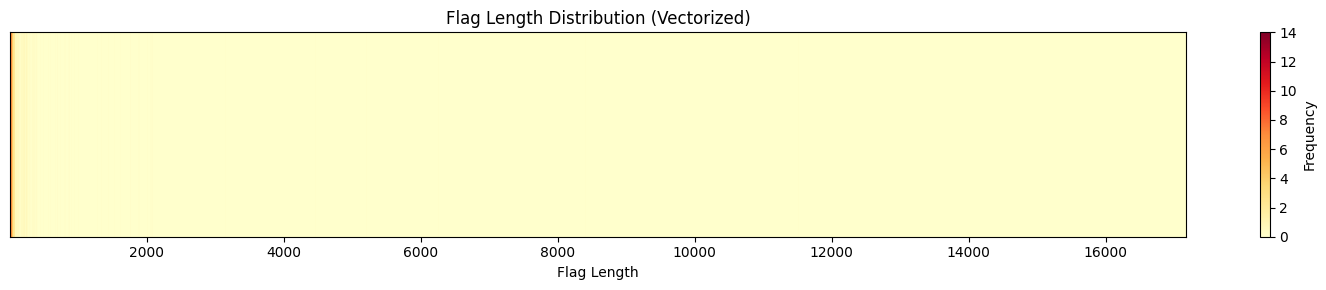

In [19]:
import matplotlib.pyplot as plt

# 1. Extract the column as a raw numpy array
arr = df['flag_length'].values

# 2. Get the range (Vectorized Min/Max)
min_val = arr.min()
max_val = arr.max()

# 3. Vectorized Counting (The "Magic" Step)
# We subtract min_val so the counting starts at index 0
counts = np.bincount(arr - min_val)

# 4. Plotting using imshow (Faster rendering than seaborn heatmap)
plt.figure(figsize=(15, 3))

# Reshape to 2D: (1 row, N columns) so it looks like a strip
heatmap_matrix = counts.reshape(1, -1)

# 'extent' fixes the X-axis labels to match your actual flag_lengths
plt.imshow(heatmap_matrix, cmap='YlOrRd', aspect='auto',
           extent=[min_val, max_val, 0, 1])

plt.gca().set_yticks([])  # Hide Y-axis numbers
plt.xlabel("Flag Length")
plt.title("Flag Length Distribution (Vectorized)")
plt.colorbar(label='Frequency')
plt.tight_layout()
plt.show()

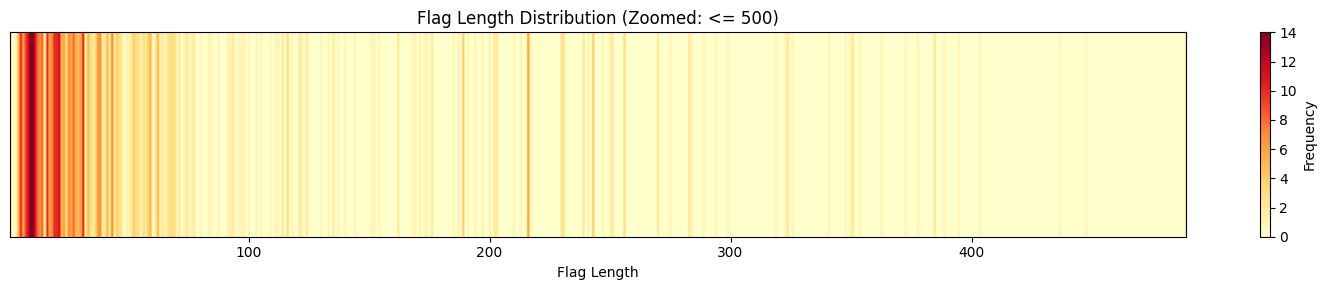

In [20]:
# Assume 'df' is your DataFrame
# 1. FILTER: Keep only values <= 500
subset = df[df['flag_length'] <= 500]
arr = subset['flag_length'].values

# 2. Get the new range
min_val = arr.min()
max_val = arr.max()

# 3. Vectorized Counting
# Subtract min_val so we start counting from index 0
counts = np.bincount(arr - min_val)

# 4. Plot
plt.figure(figsize=(15, 3))

# Reshape to (1 row, N columns)
heatmap_matrix = counts.reshape(1, -1)

# 'extent' ensures the X-axis labels match the actual numbers (from min to max)
plt.imshow(heatmap_matrix, cmap='YlOrRd', aspect='auto',
           extent=[min_val, max_val, 0, 1])

plt.gca().set_yticks([])  # Hide Y-axis
plt.xlabel("Flag Length")
plt.title("Flag Length Distribution (Zoomed: <= 500)")
plt.colorbar(label='Frequency')
plt.tight_layout()
plt.show()

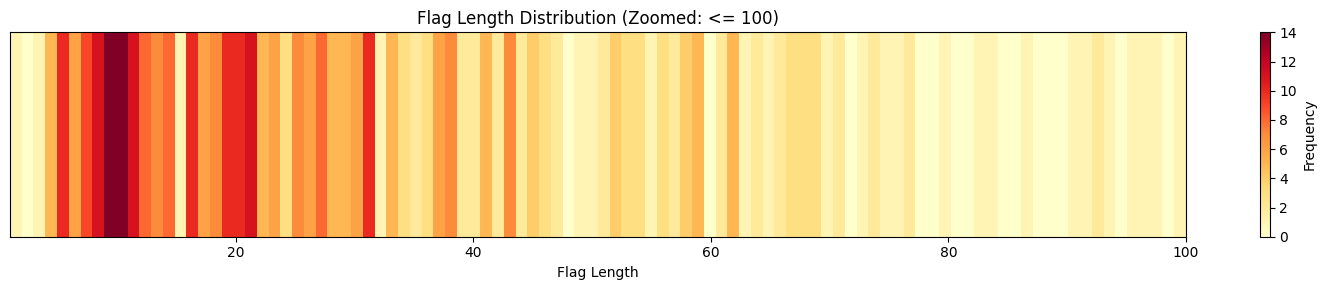

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Assume 'df' is your DataFrame
# 1. FILTER: Keep only values <= 100
subset = df[df['flag_length'] <= 100]
arr = subset['flag_length'].values

# 2. Get the new range
min_val = arr.min()
max_val = arr.max()

# 3. Vectorized Counting
# Subtract min_val so we start counting from index 0
counts = np.bincount(arr - min_val)

# 4. Plot
plt.figure(figsize=(15, 3))

# Reshape to (1 row, N columns)
heatmap_matrix = counts.reshape(1, -1)

# 'extent' ensures the X-axis labels match the actual numbers (from min to max)
plt.imshow(heatmap_matrix, cmap='YlOrRd', aspect='auto',
           extent=[min_val, max_val, 0, 1])

plt.gca().set_yticks([])  # Hide Y-axis
plt.xlabel("Flag Length")
plt.title("Flag Length Distribution (Zoomed: <= 100)")
plt.colorbar(label='Frequency')
plt.tight_layout()
plt.show()

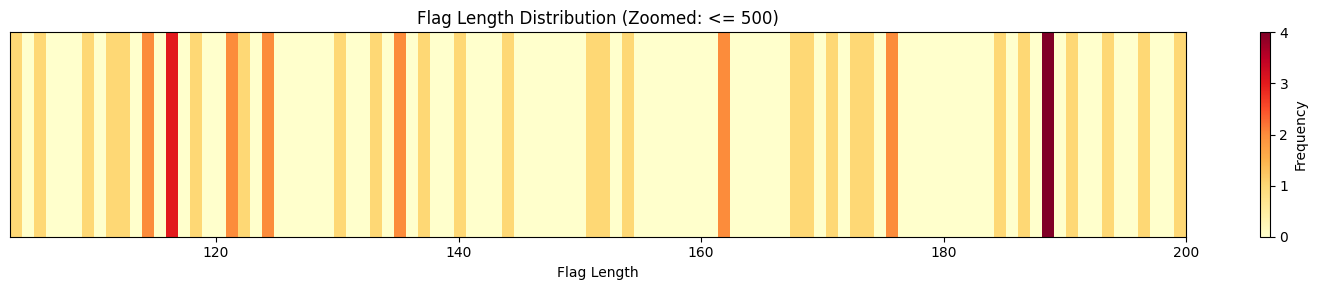

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assume 'df' is your DataFrame
# 1. FILTER: Keep only values <= 500
subset = df[(df['flag_length'] <= 200) & (df['flag_length'] > 100)]
arr = subset['flag_length'].values

# 2. Get the new range
min_val = arr.min()
max_val = arr.max()

# 3. Vectorized Counting
# Subtract min_val so we start counting from index 0
counts = np.bincount(arr - min_val)

# 4. Plot
plt.figure(figsize=(15, 3))

# Reshape to (1 row, N columns)
heatmap_matrix = counts.reshape(1, -1)

# 'extent' ensures the X-axis labels match the actual numbers (from min to max)
plt.imshow(heatmap_matrix, cmap='YlOrRd', aspect='auto',
           extent=[min_val, max_val, 0, 1])

plt.gca().set_yticks([])  # Hide Y-axis
plt.xlabel("Flag Length")
plt.title("Flag Length Distribution (Zoomed: <= 200 & > 100)")
plt.colorbar(label='Frequency')
plt.tight_layout()
plt.show()

In [22]:
import pandas as pd
import numpy as np

# Assume 'df' is your existing dataframe
# df = ...

# 1. Define your bin size
BIN_SIZE = 100

# 2. Create dynamic bin edges
# We go from 0 up to the max value + padding
max_val = df['flag_length'].max()
bins = range(0, max_val + BIN_SIZE, BIN_SIZE)

# 3. Cut the data
# right=False means intervals are [Left, Right)
df['range_group'] = pd.cut(df['flag_length'], bins=bins, right=False)

# 4. Count and Sort
# sort_index() ensures the bins appear in numerical order (0-64, then 64-128, etc.)
counts = df['range_group'].value_counts().sort_index()

print(counts)

range_group
[0, 100)          350
[100, 200)         45
[200, 300)         42
[300, 400)         18
[400, 500)          4
                 ... 
[16700, 16800)      0
[16800, 16900)      0
[16900, 17000)      0
[17000, 17100)      0
[17100, 17200)      1
Name: count, Length: 172, dtype: int64


Azt látjuk, hogy a zászlók 80%-a 512 alatt van, ezek alapján a window szélességnek 512 -t választottam

(A skálázást a Dataloader végzi majd, így nyugodtan lehet módosítani az értéket tanításkor egyébként 🙂 )

# Defining Dataset and showing a couple of examples


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import numpy as np
import pandas as pd
import os
import torch.nn.functional as F

class FlagDataset(Dataset):
    def __init__(self, csv_file, target_length=1024):
        self.data_frame = pd.read_csv(csv_file)
        self.target_length = target_length
        self.classes = ['Bearish Normal', 'Bearish Pennant', 'Bearish Wedge', 'Bullish Normal', 'Bullish Pennant', 'Bullish Wedge']
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Load raw data
        file_path = self.data_frame.iloc[idx]['flag_prices_npy_full_path']
        seq_numpy = np.load(file_path).astype(np.float32)

        # Preprocessing ("center vertically", upscale/downscale to fixed width)
        if seq_numpy.max() - seq_numpy.min() > 0:
            norm_seq = (seq_numpy - seq_numpy.min()) / (seq_numpy.max() - seq_numpy.min())
        else:
            norm_seq = seq_numpy - seq_numpy

        seq = torch.from_numpy(norm_seq).view(1, 1, -1)
        seq = F.interpolate(seq, size=self.target_length, mode='linear', align_corners=False).squeeze(0)

        label_str = self.data_frame.iloc[idx]['flag_type']
        label = self.class_to_idx[label_str]

        # RETURN IDX so we can find the raw file for debug purposes!
        return seq, torch.tensor(label, dtype=torch.long), idx

A dataset betölti az eredeti 1D-array -t az input master CSV alapján, majd ezeket normalizált értékekként, adott szélességre interpolálva visszaadja

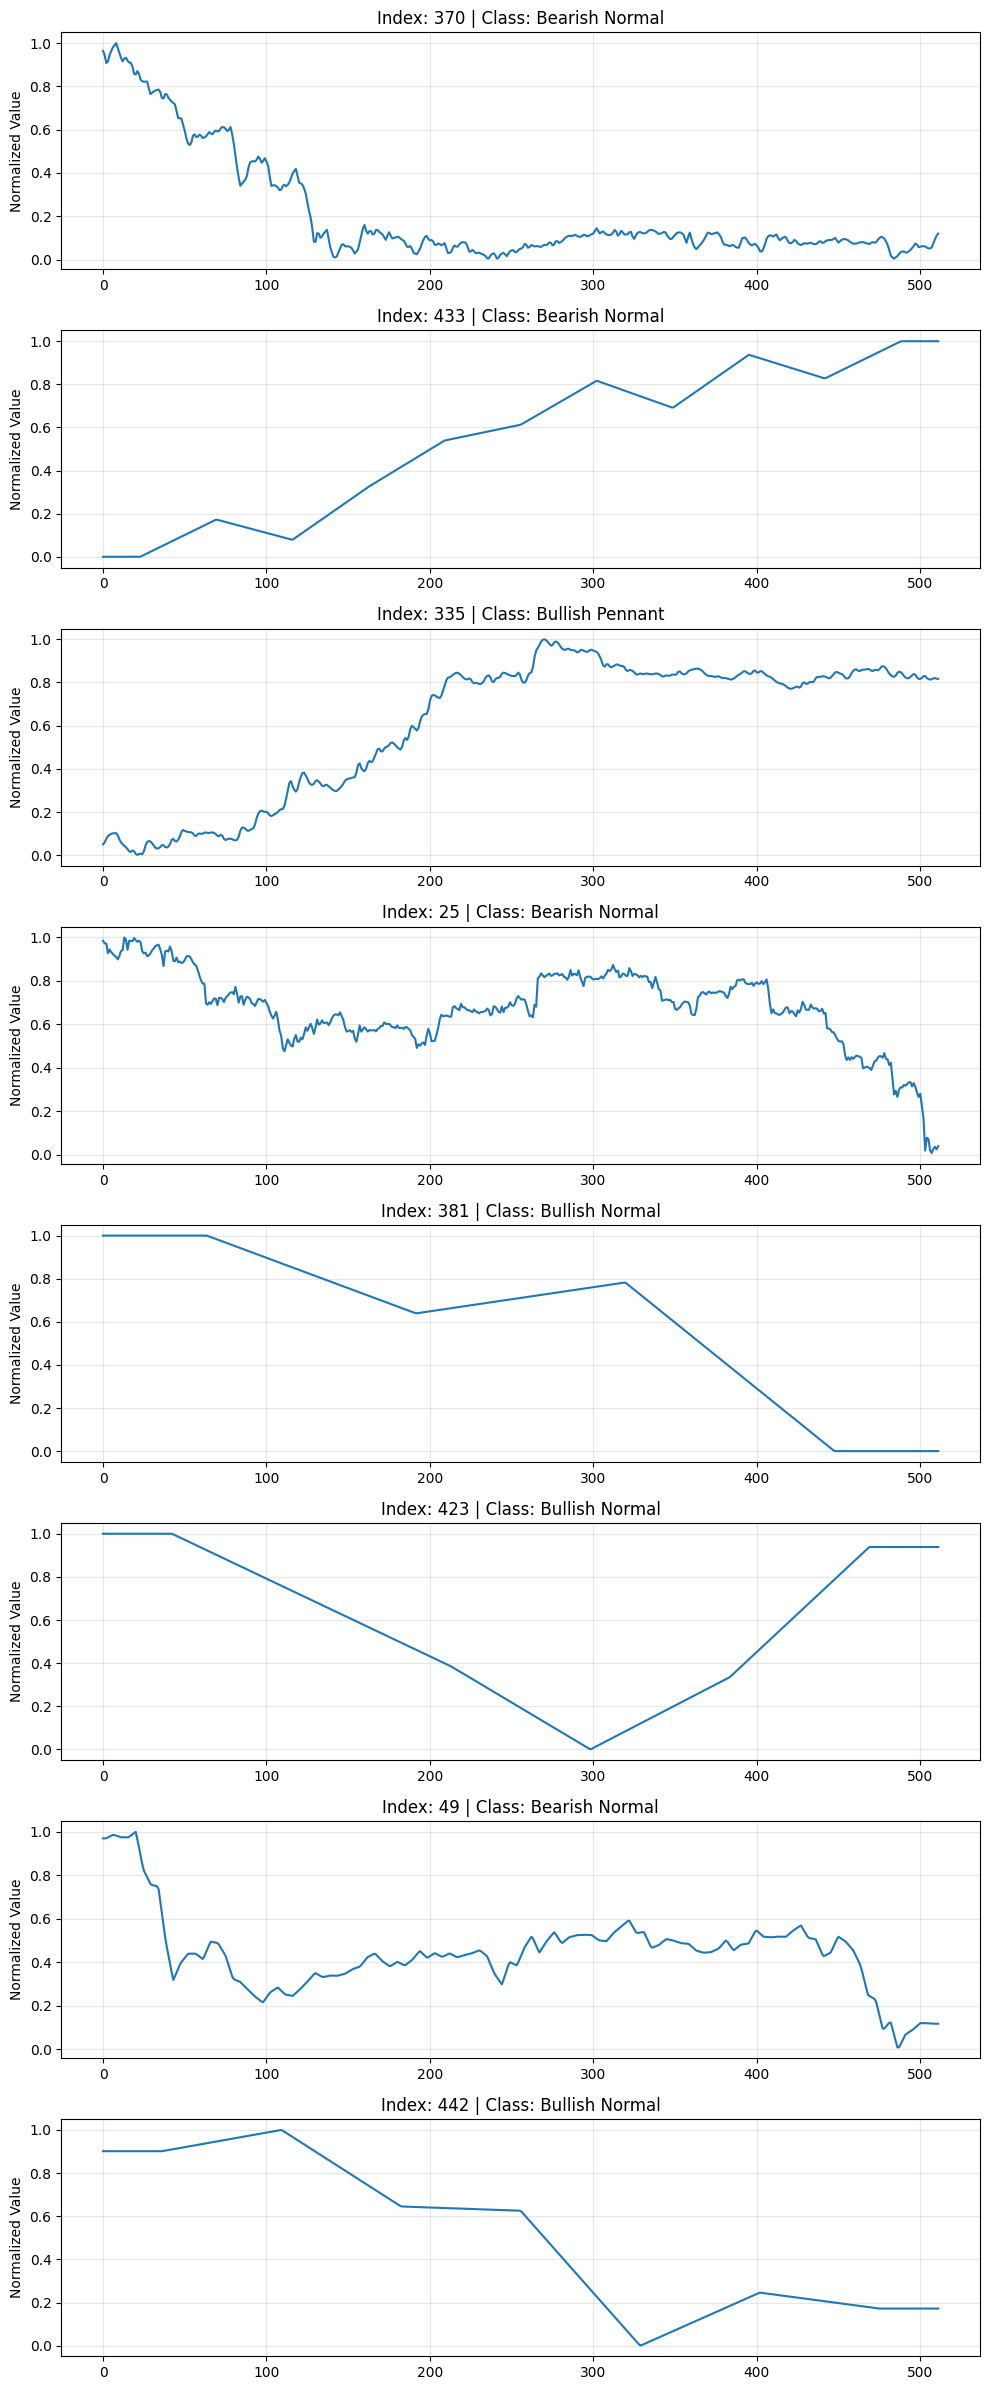

In [15]:
import matplotlib.pyplot as plt

# 1. Get a batch of data
dataset = FlagDataset(os.path.join(OUTPUT_ROOT_PATH, 'consolidated_labels.csv'), 512)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
sequences, labels, indices = next(iter(dataloader))

# 2. Configure the plot
batch_size = len(sequences)
fig, axes = plt.subplots(batch_size, 1, figsize=(10, 3 * batch_size))

# Handle the case where batch_size is 1 (axes is not a list)
if batch_size == 1:
    axes = [axes]

# 3. Iterate and plot
for i, ax in enumerate(axes):
    # Convert tensor to numpy 1D array
    # sequences[i] shape is [1, 1024], .squeeze() makes it [1024]
    signal = sequences[i].squeeze().numpy()

    # Get the string class name using the dataset's classes list
    class_name = dataset.classes[labels[i]]

    # Plot
    ax.plot(signal)
    ax.set_title(f"Index: {indices[i]} | Class: {class_name}")
    ax.set_ylabel("Normalized Value")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()